<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training the Conditional Auto-Encoder with the settings obtained from Optimization


In [37]:
import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')


import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import logging
import sys
from sklearn import preprocessing
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Reshape, LeakyReLU, BatchNormalization, Dense, Flatten, Input,Dropout
import random
import numpy as np
import pickle

In [2]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_2         = label+'_minz01_maxz036_minSN50_good'+'_10_fully_connected_mean_div'


In [3]:
random.seed(seeds[RUN])
np.random.seed(seeds[RUN])
tf.random.set_seed(seeds[RUN])




fixed_num_bins  = 1000
dim             = fixed_num_bins

optimizer       = tf.keras.optimizers.Adam
batchsize       = 33
decay_steps     = 2300
dropouts_dec    = [0.]
dropouts_enc    = [0.]
latent_dim      = 10
lr_final        = 1.3e-05
lr_init         = 7e-4
out_features    = [1000,590]
                
                   


train_data = np.load(os.path.join(root_model_data,'train_%s.npy.npz'%label_2))
valid_data = np.load(os.path.join(root_model_data,'valid_%s.npy.npz'%label_2))
test_data  = np.load(os.path.join(root_model_data,'test_%s.npy.npz'%label_2))

keys = ('spec', 'mask', 'noise', 'z', 'RA', 'DE', 'class', 'subclass', 'mean', 'std')

train = {}
for item, key in zip(train_data.files, keys):
    train[key] = train_data[item]


valid = {}
for item, key in zip(valid_data.files, keys):
    valid[key] =  valid_data[item]

test = {}
for item, key in zip(test_data.files, keys):
    test[key] = test_data[item]


le = preprocessing.LabelEncoder()
le.fit(train['subclass'])
train['subclass'] = le.transform(train['subclass'])
valid['subclass'] = le.transform(valid['subclass'])
test['subclass']  = le.transform(test['subclass'])
print(le.classes_, le.transform(le.classes_))                    



def dense_cond_block(x,z,num, non_lin=True):
    x = tf.concat([x,z], axis=1)
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)

def dense_block(x,num, non_lin=True):
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return x



def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}


def make_scheduler(length, initial_lr,factor=1.2):
    def scheduler(epoch, lr):
        if epoch < length:
            lr = initial_lr
            return lr
        else:
            return lr * tf.math.exp(-factor)
    return scheduler
                             
def training_cycle(BATCH_SIZE, n_epochs, lr_anneal, lr_initial, reduce_fac): 
    scheduler = make_scheduler(lr_anneal, lr_initial, reduce_fac)
    callback  = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history   = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_types, train_params), batch_size=BATCH_SIZE, epochs=n_epochs, callbacks=[callback],verbose=0)
    return history

def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss

[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


In [4]:
root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'

label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_2         = label+'_minz01_maxz036_minSN50_good'+'_10_fully_connected_mean_div'


train_data = np.load(os.path.join(root_model_data,'train_%s.npy.npz'%label_2))
valid_data = np.load(os.path.join(root_model_data,'valid_%s.npy.npz'%label_2))
test_data  = np.load(os.path.join(root_model_data,'test_%s.npy.npz'%label_2))

keys = ('spec', 'mask', 'noise', 'z', 'RA', 'DE', 'class', 'subclass', 'mean', 'std')

train = {}
for item, key in zip(train_data.files, keys):
    train[key] = train_data[item]


valid = {}
for item, key in zip(valid_data.files, keys):
    valid[key] =  valid_data[item]

test = {}
for item, key in zip(test_data.files, keys):
    test[key] = test_data[item]


le = preprocessing.LabelEncoder()
le.fit(train['subclass'])
train['subclass'] = le.transform(train['subclass'])
valid['subclass'] = le.transform(valid['subclass'])
test['subclass']  = le.transform(test['subclass'])
print(le.classes_, le.transform(le.classes_))                    


[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


In [38]:
pickle.dump([train,valid,test,le],open(os.path.join(root_model_data,'combined.pkl'),'wb'))

In [5]:
input        = Input(shape=(dim,1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))
input_type   = Input(shape=(1,1))
input_params = Input(shape=(1,1))

if cond_on=='type':
    z = input_type
if cond_on=='redshift':
    z = input_params

n_layers   = 3
latent_dim = latent_dim

x = input
for ii in range(n_layers-1):
    if ii>0:
        x = Dropout(dropouts_enc[ii-1])(x)
    print(ii, out_features)
    x = dense_block(x,out_features[ii])
    
x = dense_block(x,latent_dim,non_lin=False)
x = Reshape((latent_dim,1))(x)

for ii in range(n_layers-1):
    x = dense_cond_block(x,z,out_features[-1-ii])
    if ii ==0:
        pass
    else:
        x = Dropout(dropouts_dec[ii-1])(x)
x = dense_cond_block(x,z,dim, non_lin=False)


learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
lr_init,
decay_steps,
lr_final,
power=0.5, cycle=True)

optim = optimizer

lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_type, input_params], outputs=x)
lstm_ae.compile(optimizer=optim(learning_rate=learning_rate_fn), my_loss=lossFunction, metrics=[],run_eagerly=False)
lstm_ae.summary()

lstm_ae.fit(x=(train['spec'],train['mask'],train['noise'], np.expand_dims(train['subclass'],-1), np.expand_dims(train['z'],-1)), batch_size=batchsize, epochs=EPOCHS)

res_valid   = lstm_ae.predict((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']))
recon_error = custom_metric((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']),res_valid)

print('final validation loss:', recon_error)
print('final reconstruction error:', np.sqrt(recon_error))

0 [1000, 590]
1 [1000, 590]
Model: "custom_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1000)         0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 1000)         1001000     flatten[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1000)         0           dense[0][0]                      
___________________________________________________________

In [6]:
for label in np.arange(7):
    print(le.inverse_transform([label]))
    index = np.where(valid['subclass']==label)[0]
    res_valid = lstm_ae.predict((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]))
    print('validation: ', custom_metric((valid['spec'][index],valid['mask'][index],valid['noise'][index], valid['subclass'][index], valid['z'][index]),res_valid))
    index = np.where(train['subclass']==label)[0]
    lng   = min(len(res_valid),len(index))
    res_train = lstm_ae.predict((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]))
    print('training: ', custom_metric((train['spec'][index][:lng],train['mask'][index][:lng],train['noise'][index][:lng], train['subclass'][index][:lng], train['z'][index][:lng]),res_train))

[b'']
validation:  1.2614358017859384
training:  1.2499439878472416
[b'AGN']
validation:  1.3721177520930021
training:  1.5819161390921697
[b'AGN BROADLINE']
validation:  2.2629210770248083
training:  1.8293140654210527
[b'BROADLINE']
validation:  1.875983468219649
training:  1.700243442962861
[b'STARBURST']
validation:  1.6352000682035135
training:  1.5647470014923335
[b'STARBURST BROADLINE']
validation:  1.7617088573622621
training:  1.752657800977527
[b'STARFORMING']
validation:  1.4346124153796584
training:  1.4258070142521033


In [7]:
path = os.path.join(root_models,'full_ae_model_%s_%s_run%s'%(label_2,cond_on,RUN))
lstm_ae.save(path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/full_ae_model_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_good_10_fully_connected_mean_div_type_run1/assets


In [8]:
def bootstrap(train_data, batch_size):
    index   = np.arange(len(train['spec']))
    metrics = []
    for ii in range(1000):
        sample = np.random.choice(index, size=batch_size, replace=False, p=None)
        res_train = lstm_ae.predict((train['spec'][sample],train['mask'][sample],train['noise'][sample], train['subclass'][sample],train['z'][sample]))
        metric    = custom_metric((train['spec'][sample],train['mask'][sample],train_data['noise'][sample], train['subclass'][sample],train['z'][sample]),res_train)
        metrics.append(metric)
    return np.mean(metrics), np.std(metrics)

In [9]:
bootstrap(train, batch_size=len(valid_data))

(1.3259045510854703, 0.10726629476065278)

In [10]:
### concatenate and split input

def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        new_model.add(curr_layer)
    return new_model

In [11]:
def extract_layers_base(main_model, starting_layer_ix, ending_layer_ix):
    layers=[]
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(ix, curr_layer)
        layers.append(curr_layer)
    return layers

In [12]:
encoder = extract_layers(lstm_ae,0,10)
encoder.build((None,fixed_num_bins,1))
encoder.summary()

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x2aaaaeb9beb0>
1 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac0b8f9490>
2 <tensorflow.python.keras.layers.core.Dense object at 0x2aac0b8f9af0>
3 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac0b8f9280>
4 <tensorflow.python.keras.layers.core.Dropout object at 0x2aac0b8f9250>
5 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac0b92a910>
6 <tensorflow.python.keras.layers.core.Dense object at 0x2aac0b94d190>
7 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac0c196ca0>
8 <tensorflow.python.keras.layers.core.Flatten object at 0x2aab8f097f40>
9 <tensorflow.python.keras.layers.core.Dense object at 0x2aac0b8f4e50>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1000)              0         
____________

In [13]:
decoder = extract_layers_base(lstm_ae,12,26)

input      = Input(shape=(latent_dim,1))
input_type = Input(shape=(1,1))
print(decoder[0])
x          = decoder[0]((input,input_type))
for ii in range(1,len(decoder)):
    try:
        x = decoder[ii](x)
    except:
        x = decoder[ii]((x, input_type))


12 <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x2aac0c1adbb0>
13 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac0c1addf0>
14 <tensorflow.python.keras.layers.core.Dense object at 0x2aac0c1adca0>
15 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac0c1b3c70>
16 <tensorflow.python.keras.layers.core.Reshape object at 0x2aac0c1bf9a0>
17 <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x2aac0c1d2c70>
18 <tensorflow.python.keras.layers.core.Flatten object at 0x2aac0c1bf0d0>
19 <tensorflow.python.keras.layers.core.Dense object at 0x2aac0c1d2280>
20 <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x2aac0c1d98e0>
21 <tensorflow.python.keras.layers.core.Reshape object at 0x2aac0c1d9c40>
22 <tensorflow.python.keras.layers.core.Dropout object at 0x2aac0c1d9d30>
23 <tensorflow.python.keras.engine.base_layer.TensorFlowOpLayer object at 0x2aac0c1e72e0>
24 <tensorflow.python.keras.laye

In [14]:
decoder = Model((input,input_type),x)

In [15]:
decoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
tf_op_layer_concat (TensorFlowO multiple             0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 11)           0           tf_op_layer_concat[1][0]     

In [16]:
encoded_valid = encoder.predict(valid['spec'])
encoded_train = encoder.predict(train['spec'])
encoded_test  = encoder.predict(test['spec'])

In [17]:
valid['subclass']

array([0, 0, 0, ..., 0, 4, 0])

In [18]:
decoded_valid = decoder.predict((np.expand_dims(encoded_valid,-1), np.expand_dims(valid['z'],-1)))
decoded_train = decoder.predict((np.expand_dims(encoded_train,-1), np.expand_dims(train['z'],-1)))
decoded_test  = decoder.predict((np.expand_dims(encoded_test,-1), np.expand_dims(test['z'],-1)))

In [19]:
path = os.path.join(root_models,'encoder_%s_%s_run%s'%(label_2,cond_on, RUN))
encoder.save(path)
path = os.path.join(root_models,'decoder_%s_%s_run%s'%(label_2, cond_on, RUN))
decoder.save(path)
print(path)

INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/encoder_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_good_10_fully_connected_mean_div_type_run1/assets
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_good_10_fully_connected_mean_div_type_run1/assets
/global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz01_maxz036_minSN50_good_10_fully_connected_mean_div_type_run1


In [20]:
path = os.path.join(root_models,'encoder_%s_%s_run%s'%(label_2,cond_on, RUN))
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s_%s_run%s'%(label_2, cond_on, RUN))
decoder = tf.keras.models.load_model(path)

In [21]:
np.save(os.path.join(root_encoded,'encoded_%s_%s_RUN%s.npy'%(label_2,cond_on,RUN)),[encoded_train, encoded_valid, encoded_test])
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_%s_RUN%s.npy'%(label_2,cond_on, RUN)), allow_pickle=True)

In [22]:
np.save(os.path.join(root_decoded,'decoded_%s.npy'%label_2),[decoded_train,decoded_valid, decoded_test, train['mean']])

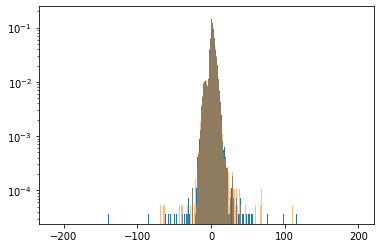

In [23]:
_=plt.hist(encoded_valid.flatten(),bins=1000,density=True, log=True)
_=plt.hist(encoded_train[:len(encoded_valid)].flatten(),bins=1000,density=True, alpha=0.5, log=True)

In [24]:
len(encoded_valid)

6596

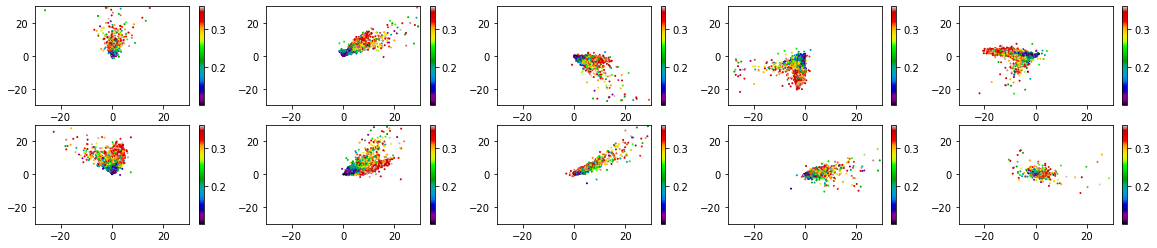

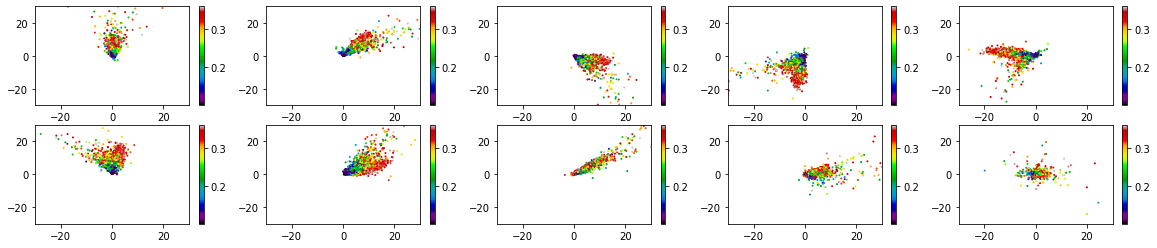

In [25]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['z'], cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:len(encoded_valid),ii],encoded_train[:len(encoded_valid),jj],c=train['z'][:len(encoded_valid)], cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

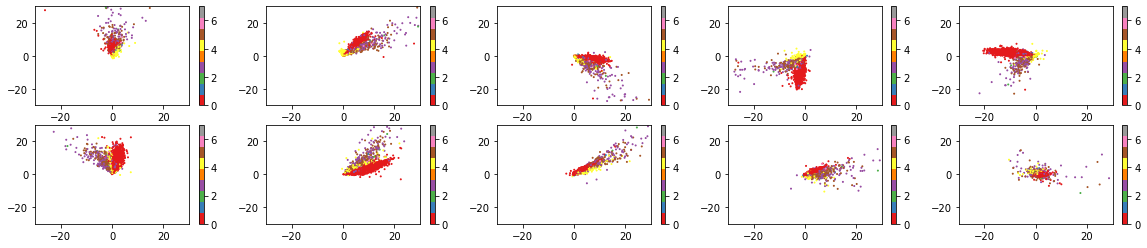

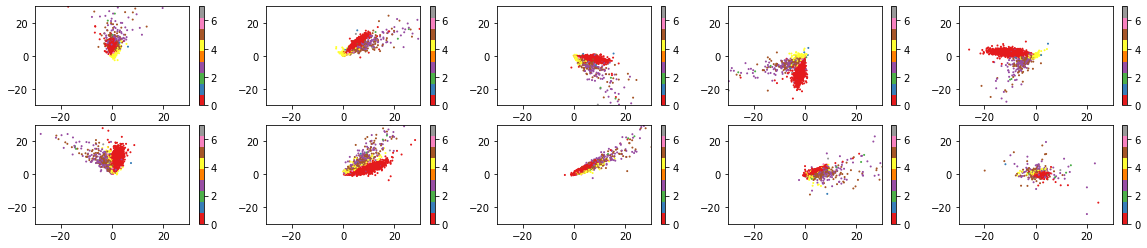

In [26]:
lims = 30

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid['subclass'], cmap='Set1', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

fig, ax = plt.subplots(2,latent_dim//2, figsize=(20,4))
ax=ax.flatten()
for ii in range(latent_dim):
    jj= (ii+1)%latent_dim
    im = ax[ii].scatter(encoded_train[:len(encoded_valid),ii],encoded_train[:len(encoded_valid),jj],c=train['subclass'][:len(encoded_valid)], cmap='Set1', s=1)
    plt.colorbar(im, ax=ax[ii])
    ax[ii].set_xlim(-lims,lims)
    ax[ii].set_ylim(-lims,lims)
plt.show()

In [27]:
wlmin, wlmax    = (3388,8318)
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

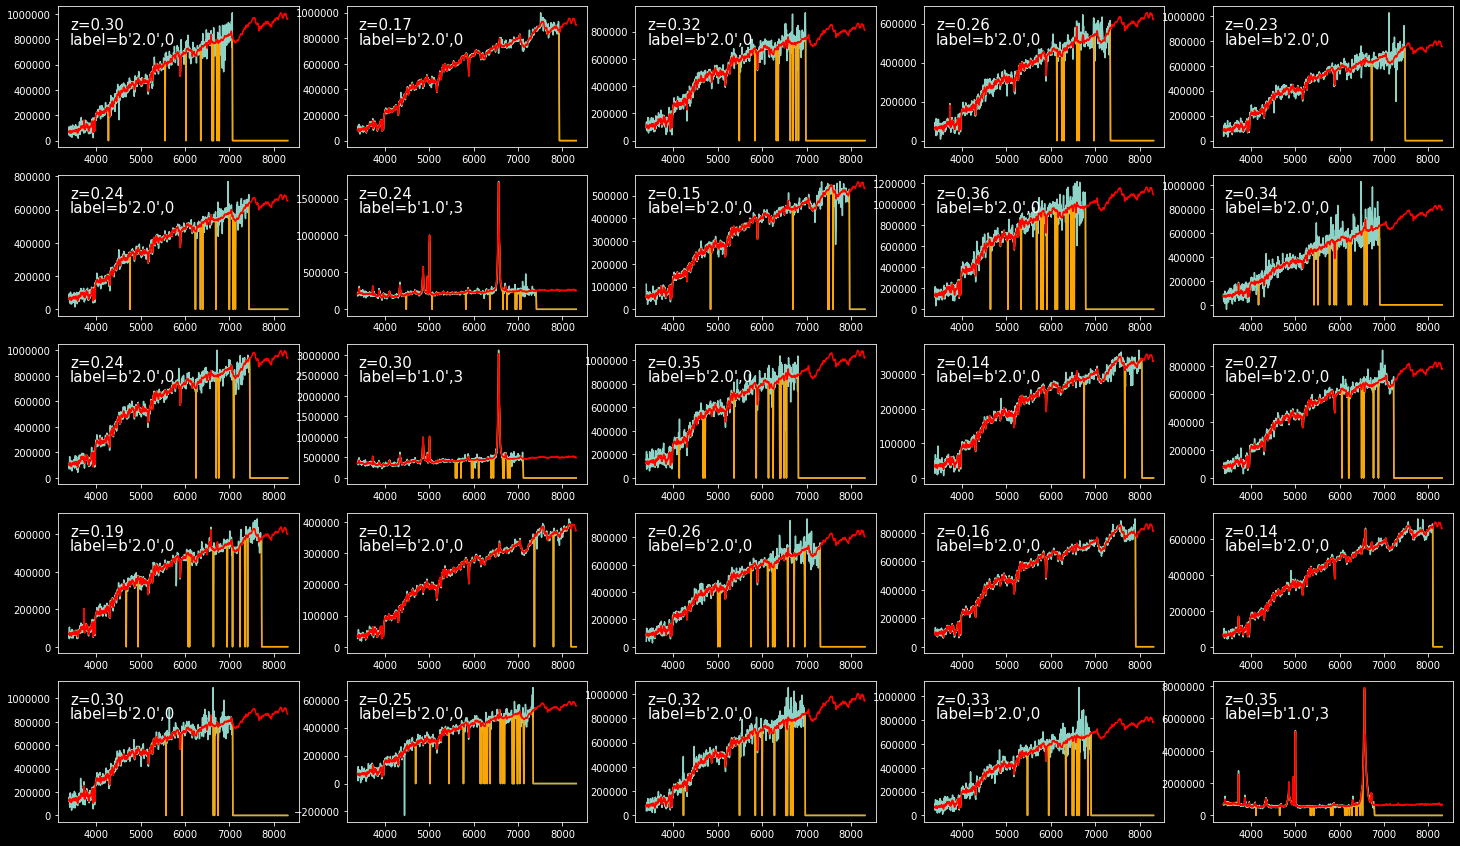

In [28]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(np.arange(25)):
                ax[nn].plot(new_wl[:-1], (np.squeeze(valid['spec']*train['std'])[ii]+train['mean'])*np.squeeze(valid['mask'])[ii], )
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid*train['std'])[ii]+train['mean'])*np.squeeze(valid['mask'])[ii], color='orange')
                ax[nn].plot(new_wl[:-1], (np.squeeze(decoded_valid*train['std'])[ii]+train['mean']), color='red')
                ax[nn].text(0.05, 0.92, r'z=%.2f'%valid['z'][ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'label=%s,%s'%(valid['class'][ii],valid['subclass'][ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
plt.show()

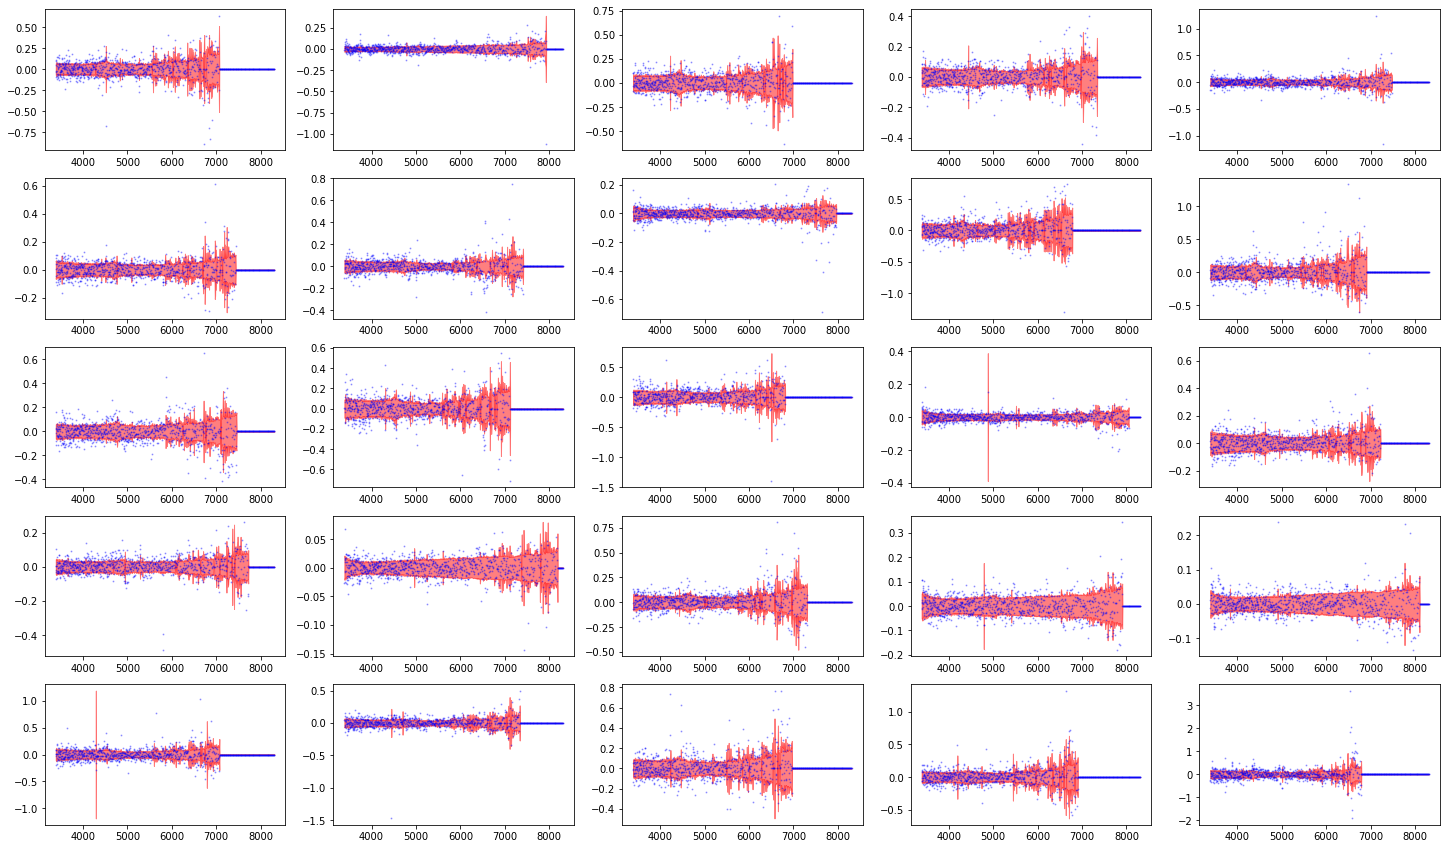

In [29]:
noise = np.zeros(valid['noise'].shape)
ind   = np.where(valid['noise']!=0)
noise[ind] = np.sqrt(1./np.squeeze(valid['noise'][ind]))

noise = np.squeeze(noise)


fig, ax = plt.subplots(5,5, figsize=(25,15))
ax = ax.flatten()
for nn, ii in enumerate(np.arange(25)):
    ax[nn].plot(new_wl[:-1], (np.squeeze(valid['spec'])[ii]-decoded_valid[ii])*np.squeeze(valid['mask'][ii]),color='blue', alpha=0.3,ls='',marker='o', markersize=1)
    ax[nn].fill_between(new_wl[:-1], -noise[ii], noise[ii], alpha=0.5, color='red')               
plt.show()

In [30]:
### Look at reconstruction ability as function of wavelength

In [31]:
def loss_by_wl(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]*y_true[1]
    valid_loss     = np.mean(loss,axis=0)
    std_valid_loss = np.std(loss,axis=0)
    return valid_loss, std_valid_loss

In [32]:
loss = loss_by_wl((valid['spec'],valid['mask'],valid['noise']),np.expand_dims(decoded_valid,-1))

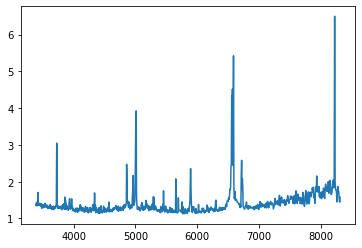

In [33]:
plt.plot(new_wl[:-1],loss[0]/np.mean(valid['mask'],axis=0))

In [34]:
np.mean(loss[0]/np.mean(valid['mask'],axis=0))

1.387899590535142

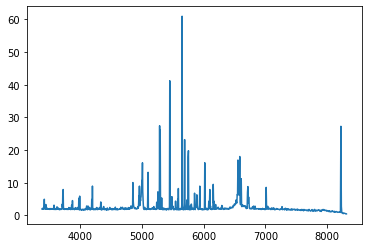

In [35]:
plt.plot(new_wl[:-1],loss[1])